# Data Preprocessing

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

###Install yahoo finance library

In [ ]:
!pip install yfinance

### Import dataset from yahoo finance

In [ ]:
import yfinance as yf
dataset = yf.download('AAPL', start='2010-01-01', end='2020-01-01')

In [ ]:
dataset.head()

## Checking for Missing values

In [ ]:
import missingno as msno
msno.matrix(dataset)
print('Data columns with null value(s): ', dataset.isnull().sum(), sep='\n')

## New product release

In [6]:
new_product = np.zeros(len(dataset.axes[0]))

# The below dates only include iPhone, iPad, and Apple Watch releases.
# Source: https://en.wikipedia.org/wiki/Timeline_of_Apple_Inc._products
new_product_release_dates = ['2010-04-3', '2010-04-30', '2010-06-24', '2010-09-1',
                             '2011-02-10', '2011-03-11', '2011-10-14',
                             '2012-03-16', '2012-09-21', '2012-11-02', '2012-11-16',
                             '2013-09-20', '2013-11-01', '2013-11-12',
                             '2014-11-18', '2014-09-19', '2014-10-22',
                             '2015-04-24', '2015-09-09', '2015-09-25', '2015-11-11',
                             '2016-03-31', '2016-09-07', '2016-09-07', '2016-09-16', '2016-10-28', '2016-12-19',
                             '2017-03-21', '2017-03-24', '2017-06-05', '2017-09-22', '2017-11-03',
                             '2018-03-27', '2018-09-21', '2018-10-26', '2018-10-30', '2018-11-07',
                             '2019-03-18', '2019-03-20', '2019-09-20', '2019-09-25', '2019-12-10']

# July 24th, 2020 is the expected release date of Apple iPhone 12
new_product_release_data_in_2020 = ['2020-03-18', '2020-04-24', '2020-07-24']

for i in range(0,len(dataset.axes[0])):
  if dataset.iloc[i, 0] in new_product_release_dates:
    new_product[i] = 1

In [ ]:
dataset['new product'] = new_product

## Get training set

In [10]:
training_set = dataset.iloc[:, :].values

## Feature Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(training_set)

## Creating a data structure with 60 time steps and 1 output

In [13]:
X_train = []
y_train = []

n_past = 60 #number of days in the past we want to take under consideration
n_future = 1 #number of days we want to predict in the future

for i in range(n_past, len(train_scaled) - n_future + 1):
  X_train.append(train_scaled[i - n_past:i, :])
  y_train.append(train_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train.shape

(2456, 60, 7)

# Build the RNN

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Using TensorFlow backend.


In [16]:
regressor = Sequential()

## Add four LSTM layers and dropout regularisation

In [17]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 7)))
regressor.add(Dropout(0.2))

In [18]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [19]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [20]:
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

## Add the output layer

In [21]:
regressor.add(Dense(units = 1))

## Compiling the RNN

In [22]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Fitting RNN to training set

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

history = regressor.fit(X_train, y_train, shuffle=True,
                        epochs=25, callbacks=[es, rlr,mcp, tb], validation_split=0.2, verbose=1, batch_size=64)

# Making predictions

## Get real price

In [ ]:
dataset_test = yf.download('AAPL', start='2020-01-01', end='2020-07-01')
real_stock_price = dataset_test.iloc[:, 1:2].values

## Add new product release date to real price

In [25]:
new_product_2020 = np.zeros(len(dataset_test))
for i in range(0,len(dataset_test.axes[0])):
  if dataset_test.iloc[i, 0] in new_product_release_data_in_2020:
    new_product_2020[i] = 1

In [26]:
dataset_test['new product'] = new_product_2020

In [37]:
dataset_test.shape

(125, 7)

## Get predicted price

In [28]:
dataset_total = pd.concat((dataset, dataset_test), axis = 0)

In [30]:
inputs = dataset_total[(len(dataset_total) - len(dataset_test) - n_past):].values
inputs = sc.transform(inputs)

In [60]:
X_test = []
for i in range(n_past, n_past + len(dataset_test)):
  X_test.append(inputs[i - n_past:i, :])
X_test = np.array(X_test)

In [67]:
predicted_stock_price = regressor.predict(X_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:,0:1])

predicted_stock_price = sc_predict.inverse_transform(predicted_stock_price)

# Visualize

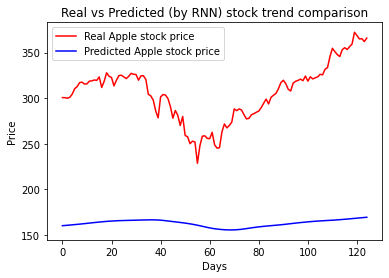

In [71]:
plt.plot(real_stock_price, color='red', label='Real Apple stock price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Apple stock price')
plt.title('Real vs Predicted (by RNN) stock trend comparison')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()